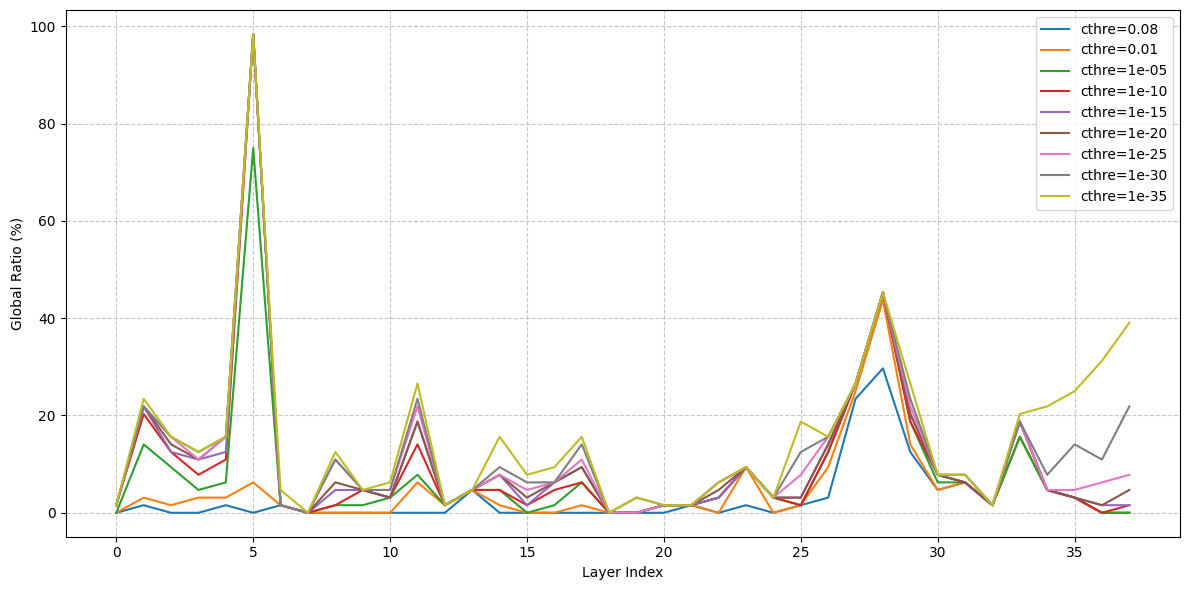

In [4]:
import torch
import matplotlib.pyplot as plt
import os

cthres = [8e-2, 1e-2, 1e-5, 1e-10, 1e-15, 1e-20, 1e-25, 1e-30, 1e-35]
num_layers = 38

results = []

for cthre in cthres:
    layer_results = []
    for layer_idx in range(num_layers):
        tA_prod_path = f"/data/kxia2/mamba_cleaned/artifacts/Zamba2-1.2B-thepile_new-clampTop0.01-max/tA_prod/tA_prod_layer_{layer_idx}.pt"

        if not os.path.exists(tA_prod_path):
            print(f"File not found: {tA_prod_path}")
            continue

        tA_prod = torch.load(tA_prod_path, map_location="cpu")
        channel_mask = tA_prod > cthre
        activation_ratio = (channel_mask.sum() / channel_mask.shape[0]) * 100
        layer_results.append(round(activation_ratio.item(), 2))
    results.append(layer_results)

plt.figure(figsize=(12, 6))
for idx, cthre in enumerate(cthres):
    plt.plot(range(num_layers), results[idx], label=f"cthre={cthre}")

plt.xlabel("Layer Index")
plt.ylabel("Global Ratio (%)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


In [14]:
import torch

for cthre in [1e-1, 1e-2, 1e-5, 1e-10, 1e-15, 1e-20]:
    for layer_idx in range(24):
        tA_prod_path = f"/data/kxia2/mamba_cleaned/artifacts/Zamba2-1.2B-thepile_new-clampTop0.15-avg/tA_prod/tA_prod_layer_{layer_idx}.pt"

        tA_prod = torch.load(tA_prod_path, map_location="cpu")
        channel_mask = tA_prod > cthre
        print("cthre", cthre, end=": ")
        print(f"{round((channel_mask.sum()/channel_mask.shape[0]).item() * 100, 1)}%", end=" ")
    print()

cthre 0.1: 0.0% cthre 0.1: 1.6% cthre 0.1: 0.0% cthre 0.1: 1.6% cthre 0.1: 3.1% cthre 0.1: 0.0% cthre 0.1: 1.6% cthre 0.1: 0.0% cthre 0.1: 0.0% cthre 0.1: 0.0% cthre 0.1: 0.0% cthre 0.1: 3.1% cthre 0.1: 1.6% cthre 0.1: 4.7% cthre 0.1: 0.0% cthre 0.1: 0.0% cthre 0.1: 0.0% cthre 0.1: 0.0% cthre 0.1: 0.0% cthre 0.1: 0.0% cthre 0.1: 0.0% cthre 0.1: 1.6% cthre 0.1: 0.0% cthre 0.1: 1.6% 
cthre 0.01: 0.0% cthre 0.01: 6.2% cthre 0.01: 3.1% cthre 0.01: 3.1% cthre 0.01: 3.1% cthre 0.01: 9.4% cthre 0.01: 1.6% cthre 0.01: 0.0% cthre 0.01: 1.6% cthre 0.01: 0.0% cthre 0.01: 0.0% cthre 0.01: 6.2% cthre 0.01: 1.6% cthre 0.01: 4.7% cthre 0.01: 1.6% cthre 0.01: 0.0% cthre 0.01: 0.0% cthre 0.01: 4.7% cthre 0.01: 0.0% cthre 0.01: 0.0% cthre 0.01: 1.6% cthre 0.01: 1.6% cthre 0.01: 0.0% cthre 0.01: 9.4% 
cthre 1e-05: 0.0% cthre 1e-05: 17.2% cthre 1e-05: 10.9% cthre 1e-05: 6.2% cthre 1e-05: 6.2% cthre 1e-05: 90.6% cthre 1e-05: 1.6% cthre 1e-05: 0.0% cthre 1e-05: 1.6% cthre 1e-05: 3.1% cthre 1e-05: 3.1% cthre

In [ ]:
import json
import os

best_ours = {}
second_ours = {}
init = False

result_dir = "/data/kxia2/mamba_cleaned/pred_ppl/subseq_lambada"
files = [i for i in os.listdir(result_dir) if "1.0.json" in i and "max" in i and "clampTop0.10" in i]

for name in files:
    result_path = os.path.join(result_dir, name)
    
    try:
        with open(result_path) as f:
            result = json.load(f)
    except Exception as e:
        print(f"Error opening or loading {result_path}: {e}")
        continue

    if not init:
        for key in result:
            best_ours[key] = str(1e10)
            best_ours[key + "_path"] = ""
            second_ours[key] = str(1e10)
            second_ours[key + "_path"] = ""
        init = True

    for key in result:
        current_ppl = float(result[key])
        best_ppl = float(best_ours[key])
        second_ppl = float(second_ours[key])

        if current_ppl < best_ppl:
            second_ours[key] = best_ours[key]
            second_ours[key + "_path"] = best_ours[key + "_path"]

            best_ours[key] = result[key]
            best_ours[key + "_path"] = name
        elif current_ppl < second_ppl and name != best_ours[key + "_path"]:
            second_ours[key] = result[key]
            second_ours[key + "_path"] = name


print("Ours best result and path:")
for key in best_ours:
    if not key.endswith("_path"):
        print(f"{key}: {best_ours[key]} (Path: {best_ours[key + '_path']})")

print("\nOurs second best result and path:")
for key in second_ours:
    if not key.endswith("_path"):
        print(f"{key}: {second_ours[key]} (Path: {second_ours[key + '_path']})")

Ours best result and path:
2k: 9.6053 (Path: Zamba2-1.2B_thepile_new-clampTop0.18-max-dt_thre-4e-05-1.0.json)
8k: 1670.2971 (Path: Zamba2-1.2B_thepile_new-clampTop0.18-max-dt_thre-9e-05-1.0.json)
16k: 143.0513 (Path: Zamba2-1.2B_thepile_new-clampTop0.18-max-dt_thre-0.007-1.0.json)
24k: 173.6484 (Path: Zamba2-1.2B_thepile_new-clampTop0.18-max-dt_thre-0.007-1.0.json)
32k: 171.9816 (Path: Zamba2-1.2B_thepile_new-clampTop0.18-max-dt_thre-0.007-1.0.json)
40k: 187.3167 (Path: Zamba2-1.2B_thepile_new-clampTop0.18-max-dt_thre-0.009-1.0.json)
average: 397.9276 (Path: Zamba2-1.2B_thepile_new-clampTop0.18-max-dt_thre-9e-05-1.0.json)

Ours second best result and path:
2k: 9.6053 (Path: Zamba2-1.2B_thepile_new-clampTop0.18-max-dt_thre-0.0006-1.0.json)
8k: 2146.6499 (Path: Zamba2-1.2B_thepile_new-clampTop0.18-max-dt_thre-4e-05-1.0.json)
16k: 145.4285 (Path: Zamba2-1.2B_thepile_new-clampTop0.18-max-dt_thre-0.0006-1.0.json)
24k: 177.7042 (Path: Zamba2-1.2B_thepile_new-clampTop0.18-max-dt_thre-0.04-1.0